In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nfl_data_py as nfl

# Define the years to import
yrs = range(2017, 2020)
#yrs = 2022

# Play-by-Play Data
pbp_data = nfl.import_pbp_data(years=yrs)

2017 done.
2018 done.
2019 done.
Downcasting floats.


# Feature Engineering

In [2]:
import numpy as np
import pandas as pd
import re

def feature_engineering(pbp_data):
    # 1. Define data
    df = pbp_data[['play_type', 'offense_formation', 'defenders_in_box', 'ydstogo', 'half_seconds_remaining', 'wp', 'ep', 'week', 'down', 'run_gap',
                   'defense_personnel', 'offense_personnel', 'number_of_pass_rushers', 'defense_man_zone_type', 'defense_coverage_type', 'yardline_100', 'xpass', 'play_clock',
                   'temp', 'wind', 'roof', 'surface', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'shotgun', 'no_huddle', 'home_team', 'posteam', 'defteam',
                   'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'score_differential', 'qtr', 'drive',
                   'game_id', 'play_id', 'epa', 'yards_gained']].sort_values(['game_id', 'play_id']).copy()

    df = df[df['play_type'].isin(['run','pass'])].copy()

    # Fill NaNs for numerical features that will be used in calculations
    df['number_of_pass_rushers'] = df['number_of_pass_rushers'].fillna(4)
    df['play_clock'] = df['play_clock'].fillna(40) # Assume 40 seconds if missing

    standard_cols = ['play_type', 'defenders_in_box', 'number_of_pass_rushers', 'ydstogo', 'half_seconds_remaining', 'wp', 'ep', 'week', 'down',
                     'yardline_100', 'xpass', 'score_differential', 'qtr', 'drive', 'temp']
    original_standard_cols = standard_cols.copy()

    # --- 2. Personnel counts and Ratios (Enhanced) ---
    df['rb_count'] = df['offense_personnel'].str.extract(r'(\d+)\s*RB').astype(float)
    df['wr_count'] = df['offense_personnel'].str.extract(r'(\d+)\s*WR').astype(float)
    df['te_count'] = df['offense_personnel'].str.extract(r'(\d+)\s*TE').astype(float)
    df['db_count'] = df['defense_personnel'].str.extract(r'(\d+)\s*DB').astype(float)
    df['lb_count'] = df['defense_personnel'].str.extract(r'(\d+)\s*LB').astype(float)
    df['dl_count'] = df['defense_personnel'].str.extract(r'(\d+)\s*DL').astype(float)
    
    # Fill personnel counts (usually 0 if not explicitly listed)
    personnel_fill_cols = ['rb_count', 'wr_count', 'te_count', 'db_count', 'lb_count', 'dl_count']
    for col in personnel_fill_cols:
        df[col] = df[col].fillna(0)


    df['wr_db_diff'] = df['wr_count'] - df['db_count']
    df['rb_lb_diff'] = df['rb_count'] - df['lb_count']
    df['blockers'] = 5 + df['te_count'] + df['rb_count'] 
    df['pressure_ratio'] = df['number_of_pass_rushers'] / (df['blockers'] + 1e-6)
    df['box_minus_rushers'] = df['defenders_in_box'] - df['number_of_pass_rushers']
    df['box_advantage'] = df['box_minus_rushers'] / (df['number_of_pass_rushers'] + 1e-6)
    df['defensive_back_density'] = df['db_count'] / (df['defenders_in_box'] + 1e-6)
    df['front_density'] = (df['dl_count'] + df['lb_count']) / (df['defenders_in_box'] + 1e-6)
    df['receiver_db_ratio'] = df['wr_count'] / (df['db_count'] + 1e-6)
    df['xpass_receivers'] = (df['wr_count'] + df['te_count']) * df['xpass']
    df['skill_vs_coverage'] = (df['rb_count'] + df['wr_count'] + df['te_count']) / (df['lb_count'] + df['db_count'] + 1e-6)
    df['box_skill_pressure'] = df['defenders_in_box'] / (df['rb_count'] + df['wr_count'] + 1e-6)
    df['coverage_complexity'] = df['db_count'] / (df['lb_count'] + 1e-6)
    df['blitz_indicator'] = df['number_of_pass_rushers'] - df['dl_count']
    df['rush_position_diversity'] = (df['lb_count'] + df['db_count']) / (df['dl_count'] + 1e-6)
    df['skill_players_total'] = df['rb_count'] + df['wr_count'] + df['te_count']
    df['receiver_blocker_balance'] = (df['wr_count'] + df['te_count']) / (df['rb_count'] + df['te_count'] + 5)
    df['blocker_to_rusher_ratio'] = df['blockers'] / (df['number_of_pass_rushers'] + 1e-6)
    df['pass_block_stress'] = df['number_of_pass_rushers'] - df['blockers']
    df['pass_advantage'] = (df['wr_count'] + df['te_count']) - df['db_count']
    df['defensive_front_leverage'] = df['dl_count'] - df['te_count']
    df['pressure_on_late_downs'] = df['pressure_ratio'] * (df['down'] >= 3).astype(int)
    df['o_formation_reuse'] = (df.groupby(['game_id', 'offense_formation']).cumcount())
    df['d_coverage_reuse'] = (df.groupby(['game_id', 'defense_coverage_type']).cumcount())

    personnel_cols = ['rb_count', 'wr_count', 'te_count', 'db_count', 'lb_count', 'dl_count',
                      'box_minus_rushers', 'box_advantage', 'defensive_back_density', 'receiver_db_ratio', 'xpass_receivers',
                      'front_density', 'pressure_ratio', 'blockers', 'wr_db_diff', 'rb_lb_diff', 'skill_vs_coverage',
                      'box_skill_pressure', 'coverage_complexity', 'blitz_indicator', 'rush_position_diversity',
                      'receiver_blocker_balance', 'blocker_to_rusher_ratio',
                      'pass_advantage', 'defensive_front_leverage', 'pressure_on_late_downs', 'o_formation_reuse', 'd_coverage_reuse'
                      ]

    # --- 3. Core features (Original + Deep Time/Non-Linear Transforms) ---
    df['log_ydstogo'] = np.log1p(df['ydstogo'])
    df['log_yardline'] = np.log1p(df['yardline_100'])
    df['garbage_time'] = ((df['wp'] <= 0.10) | (df['wp'] >= 0.90)).astype(int)
    df['two_min_warn'] = (df['half_seconds_remaining'] <= 120).astype(int)
    df['win_formation'] = ((df['wp'] >= 0.75).astype(int) & (df['half_seconds_remaining'] <= 120).astype(int))
    df['dist_down'] = df['down'] * df['ydstogo']
    df['home_field'] = (df['posteam'] == df['home_team']).astype(int)
    df['timeout_diff'] = df['posteam_timeouts_remaining'] - df['defteam_timeouts_remaining']
    df['yardline_wp'] = df['yardline_100'] * df['wp']
    df['score_diff_qtr'] = df['score_differential'] * df['qtr']
    df['score_diff_drive'] = df['score_differential'] * df['drive']
    df['epa_leverage'] = df['wp'] * (100 - df['yardline_100']) / 100
    df['critical_down'] = ((df['down'] >= 3) & (df['ydstogo'] > 5)).astype(int)
    df['crunch_time'] = ((df['qtr'] == 4) & (df['wp'] <= 0.33)).astype(int)
    df['prev_yards_gain'] = df.groupby('game_id')['yards_gained'].shift(1)
    df['overreaction'] = (df['prev_yards_gain'] >= 10).astype(int)
    df['soft_defense'] = ((df['score_differential'] >= 7) & (df['yardline_100'] >= 45) & (df['half_seconds_remaining'] <= 120)).astype(int)
    df['yardline_per_sec'] = df['yardline_100'] / (df['half_seconds_remaining'] + 1e-6)
    df['rolling_pass_plays'] = df.groupby('game_id')['play_type'].transform(lambda x: (x == 'pass').rolling(window=3, min_periods=1).sum())
    df['pass_over_expected'] = ((df['play_type'] == 'pass').astype(int) - df['xpass']).abs()
    df['rolling_pass_over_expected'] = df.groupby('posteam')['pass_over_expected'].transform(lambda x: x.rolling(window=120, min_periods=1).mean())

    # --- NEW: Deep Time and Play Clock Features ---
    df['time_pressure_quad'] = (df['half_seconds_remaining']**2) / (df['yardline_100'] + 1e-6)
    
    # Define Field Zones (Contextual Geometry) 
    def get_field_zone(yardline):
        if yardline <= 10: return 'Goal_Line'
        if yardline <= 20: return 'Red_Zone'
        if yardline >= 80: return 'Opponent_Half'
        if yardline >= 40 and yardline <= 60: return 'Midfield'
        return 'Own_Territory'
    
    df['field_zone_category'] = df['yardline_100'].apply(get_field_zone)

    core_cols = ['log_ydstogo', 'log_yardline', 'garbage_time', 'two_min_warn',
                 'win_formation', 'dist_down', 'home_field', 'timeout_diff', 'yardline_wp',
                 'score_diff_qtr', 'score_diff_drive', 'epa_leverage', 'critical_down',
                 'crunch_time', 'overreaction', 'prev_yards_gain', 'soft_defense', 'yardline_per_sec', 
                 'rolling_pass_plays', 'time_pressure_quad', 'rolling_pass_over_expected'
                 ]

    # --- 4. Situational Interaction Features (NEW GROUP) ---
    df['two_min_red_zone_int'] = df['two_min_warn'] * (df['field_zone_category'] == 'Red_Zone').astype(int)
    df['fourth_down_leverage'] = (df['down'] == 4).astype(int) * df['epa_leverage']
    df['run_gap_defenders_int'] = df['defenders_in_box'] * (df['run_gap'].isin(['end', 'guard', 'tackle'])).astype(int) # Interior vs. Box
    df['long_down_midfield'] = ((df['down'] >= 3) & (df['ydstogo'] >= 10) & (df['field_zone_category'] == 'Midfield')).astype(int)
    
    situational_cols = ['two_min_red_zone_int', 'fourth_down_leverage', 'run_gap_defenders_int', 'long_down_midfield']

    # Drop original columns used for calculations
    df = df.drop(columns=['home_team', 'offense_personnel', 'defense_personnel'], axis=1)

    # Step 5.1: Define categorical columns before dummy expansion
    # 'field_zone_category' and 'defteam' are added
    categorical_columns_raw = ['play_type', 'offense_formation', 'run_gap', 'defense_man_zone_type',
                               'defense_coverage_type', 'roof', 'surface', 'field_zone_category'
                               ]

    # Step 5.2: One-hot encode and collect dummy column names
    dummy_col_mapping = {}
    for col in categorical_columns_raw:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True, dummy_na=False) # Keep NaNs out of dummy creation
        dummy_col_mapping[col] = list(dummies.columns)
        df = pd.concat([df, dummies], axis=1)

    # Remove original categorical columns, except 'posteam' (needed for rolling)
    df.drop(columns=categorical_columns_raw, inplace=True)

    # Step 5.3: Define the new categorical_cols group
    categorical_cols = []
    for col in categorical_columns_raw:
        categorical_cols.extend(dummy_col_mapping[col])

    # Step 6: Rebuild standard_cols (numerical/binary columns only)
    standard_cols = []
    for col in original_standard_cols:
        if col not in categorical_columns_raw and col in df.columns:
            standard_cols.append(col)

    # Sanity check: Ensure no overlap
    assert len(set(standard_cols).intersection(categorical_cols)) == 0

    # --- 7. Create Rolling Averages (Enhanced with Defteam and Context) ---
    df = df.sort_values(['game_id', 'play_id']).copy() # Re-sort to ensure correct play order

    # Base features for rolling
    rol_cols_base = [col for col in categorical_cols if col.startswith(('play_type', 'offense_formation', 'run_gap', 'defense_man_zone_type',
                               'defense_coverage_type'))] + ['rb_count', 'wr_count', 'te_count', 'db_count', 'lb_count', 'dl_count',
                              'box_minus_rushers', 'box_advantage', 'defensive_back_density', 'receiver_db_ratio', 'xpass_receivers',
                              'front_density', 'pressure_ratio']
    
    rolling_cols = []
    rolling_window = 180

    # 7a. POSTEAM ROLLING (Original)
    df = df.sort_values(['posteam', 'game_id', 'play_id']).copy()
    for col in rol_cols_base:
        df[f'{col}_posteam_avg'] = df.groupby('posteam')[col].transform(lambda x: x.shift(1).rolling(window=rolling_window, min_periods=1).mean())
        rolling_cols.append(f'{col}_posteam_avg')

    # 7b. DEFTEAM ROLLING (NEW: Defensive Tendencies)
    df = df.sort_values(['defteam', 'game_id', 'play_id']).copy()
    
    # Rolling Pass/Run DVOA (Defense Vs. Offense Type)
    df['play_type_pass_dummy'] = (df['play_type_pass'] == 1).astype(int) if 'play_type_pass' in df.columns else (df['play_type_run'] == 0).astype(int)
    df['d_pass_rate_allowed_avg'] = df.groupby('defteam')['play_type_pass_dummy'].transform(lambda x: x.shift(1).rolling(window=120, min_periods=1).mean())
    rolling_cols.extend(['d_pass_rate_allowed_avg'])

    for col in rol_cols_base:
        df[f'{col}_defteam_avg'] = df.groupby('defteam')[col].transform(lambda x: x.shift(1).rolling(window=rolling_window, min_periods=1).mean())
        rolling_cols.append(f'{col}_defteam_avg')

    # Drop team identifiers after rolling calculations
    df = df.drop(columns=['posteam', 'defteam'], axis=1, errors='ignore')

    # Final feature collection: Combine personnel, core, rolling, and new situational features
    all_feature_cols = standard_cols + personnel_cols + core_cols + situational_cols + rolling_cols
    
    # Clean up the returned lists to ensure they only contain columns present in the final df
    final_categorical_cols = [col for col in categorical_cols if col in df.columns]
    final_standard_cols = [col for col in standard_cols if col in df.columns]
    final_core_cols = [col for col in core_cols if col in df.columns]
    final_personnel_cols = [col for col in personnel_cols if col in df.columns]
    final_rolling_cols = [col for col in rolling_cols if col in df.columns]
    
    # Add new situational columns to personnel list for modeling purposes if desired
    final_personnel_cols.extend(situational_cols)
    
    return df, final_categorical_cols, final_standard_cols, final_core_cols, final_personnel_cols, final_rolling_cols

# NOTE: You would call this function after loading your pbp_data
df, categorical_cols, standard_cols, core_cols, personnel_cols, rolling_cols = feature_engineering(pbp_data)
df.head()

,defenders_in_box,ydstogo,half_seconds_remaining,wp,ep,week,down,number_of_pass_rushers,yardline_100,xpass,...,db_count_defteam_avg,lb_count_defteam_avg,dl_count_defteam_avg,box_minus_rushers_defteam_avg,box_advantage_defteam_avg,defensive_back_density_defteam_avg,receiver_db_ratio_defteam_avg,xpass_receivers_defteam_avg,front_density_defteam_avg,pressure_ratio_defteam_avg
8,6.0,10.0,1620.0,0.714951,4.551717,1,1.0,4.0,26.0,0.384229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,6.0,5.0,1589.0,0.707929,4.603201,1,2.0,4.0,21.0,0.490649,...,4.000000,4.00,3.000000,2.000000,0.500000,0.666667,0.500000,1.536915,1.166666,0.500000
12,7.0,10.0,1568.0,0.376480,0.964134,1,1.0,4.0,85.0,0.418468,...,4.500000,4.00,2.500000,2.000000,0.500000,0.750000,0.550000,1.749755,1.083333,0.535714
13,5.0,10.0,1529.0,0.365545,0.347706,1,2.0,4.0,85.0,0.476366,...,4.666667,4.00,2.333333,2.333333,0.583333,0.738095,0.566667,1.724461,1.007936,0.547619
14,4.0,8.0,1491.0,0.352329,-0.198632,1,3.0,4.0,83.0,0.984085,...,4.750000,3.75,2.500000,2.000000,0.500000,0.803571,0.575000,1.769712,1.055952,0.553571


In [3]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Example: your raw features and target
X = df.drop(columns=['epa', 'game_id', 'play_id', 'yards_gained']).copy()
y = df['epa'].copy()

# Create fold splits
kf = KFold(n_splits=3, shuffle=True, random_state=99)

# Store fold indices for later reuse
folds = []
for train_idx, test_idx in kf.split(X):
    folds.append((train_idx, test_idx))

scaler = StandardScaler()
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Remove infinities and NaNs
X_train = X_train.replace([np.inf, -np.inf], 0)
X_test = X_test.replace([np.inf, -np.inf], 0)

y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

# ----------------

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

# ...existing code...
# After you've built `folds` (list of (train_idx, test_idx)) — compute out-of-fold variance_encoder
group_collection = ['down', 'play_type_run', 'defense_coverage_type_COVER_1',
                    'defense_coverage_type_COVER_0', 'defense_man_zone_type_ZONE_COVERAGE',
                    'offense_formation_SINGLEBACK', 'offense_formation_SHOTGUN', 'd_coverage_reuse',
                    'shotgun', 'no_huddle','qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'score_differential']

# Prepare an empty series aligned to df index for OOF assignment
variance_oof = pd.Series(index=df.index, dtype=float)

for train_idx, test_idx in folds:
    # Map positional fold indices to actual df index labels
    idx_train = df.index[train_idx]
    idx_test  = df.index[test_idx]

    # Compute encoder (std of epa) on training partition only
    group_means = df.loc[idx_train].groupby(group_collection)['epa'].std().reset_index().rename(columns={'epa': 'variance_encoder'})

    # Merge encoder into the test partition (left join ensures we keep test rows)
    merged_test = df.loc[idx_test].merge(group_means, on=group_collection, how='left')

    # Assign computed encoder values back to the global OOF series (preserve row alignment)
    variance_oof.loc[idx_test] = merged_test['variance_encoder'].values

# Fill remaining NaNs (e.g., unseen groups) with 0 or fallback global/group value
variance_oof = variance_oof.fillna(0.0)

# Put the encoder back into the original dataframe
df['variance_encoder'] = variance_oof

# Quick diagnostics
print("Variance encoder correlation with target EPA:", variance_oof.corr(df['epa']))
print("Variance encoder assigned. NaNs remaining:", df['variance_encoder'].isna().sum())
# ...existing code...

# ------------

# Add variance_encoder to X_train and X_test
X_train['variance_encoder'] = variance_oof.iloc[train_idx].values
X_test['variance_encoder'] = variance_oof.iloc[test_idx].values

# Apply to scaled data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

X_train_scaled = X_train_scaled.fillna(0)
X_test_scaled = X_test_scaled.fillna(0)

X_train_scaled = X_train_scaled.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test_scaled = X_test_scaled.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Variance encoder correlation with target EPA: 0.05066889095155524
Variance encoder assigned. NaNs remaining: 0


In [4]:
# Check for NaN or infinite values in X_train_scaled
print("NaN in X_train_scaled:", X_train_scaled.isna().sum().sum())
print("Inf in X_train_scaled:", np.isinf(X_train_scaled.values).sum())

# Show columns with NaN or inf
print("Columns with NaN:", X_train_scaled.columns[X_train_scaled.isna().any()].tolist())
print("Columns with Inf:", X_train_scaled.columns[np.isinf(X_train_scaled).any()].tolist())

# Show rows with NaN or inf
nan_rows = X_train_scaled[X_train_scaled.isna().any(axis=1)]
inf_rows = X_train_scaled[np.isinf(X_train_scaled).any(axis=1)]
print("Rows with NaN:", nan_rows.index.tolist())
print("Rows with Inf:", inf_rows.index.tolist())

# Repeat for y_train if needed
print("NaN in y_train:", pd.isna(y_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())

NaN in X_train_scaled: 0
Inf in X_train_scaled: 0
Columns with NaN: []
Columns with Inf: []
Rows with NaN: []
Rows with Inf: []
NaN in y_train: 0
Inf in y_train: 0


# Practice Modeling

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

def base_fold_eval(X_train_scaled, X_test_scaled, y_train, y_test, feature_cols, fold_id, label):
    """
    Fit regression on a feature group, predict, and print metrics.
    Returns predictions.
    """
    xgb_params = {
    'n_estimators': 1000, 'learning_rate': 0.0025, 'max_depth': 6, 
    'colsample_bytree': 1.0, 'subsample': 1.0, 
    'reg_lambda': 80.0, 'reg_alpha': 0.5, 'gamma': 0.15, 'random_state': 999, 
    'verbosity': 0, 'objective': 'reg:squarederror'
    }  
    base_model = xgb.XGBRegressor(**xgb_params)

    base_model.fit(X_train_scaled[feature_cols], y_train, verbose=True)
    preds = base_model.predict(X_test_scaled[feature_cols])
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    train_preds = base_model.predict(X_train_scaled[feature_cols])
    train_mse = mean_squared_error(y_train, train_preds)
    train_r2 = r2_score(y_train, train_preds)
    print(f"Fold {fold_id} {label} Base - Test MSE: {mse:.3f}, Test R^2: {r2:.3f} | Train MSE: {train_mse:.3f}, Train R^2: {train_r2:.3f}")
    return pd.DataFrame(train_preds, columns=[label+'_predictions'], index=X_train_scaled.index), pd.DataFrame(preds, columns=[label+'_predictions'], index=X_test_scaled.index), base_model

In [26]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

def base_fold_eval(X_train_scaled, X_test_scaled, y_train, y_test, feature_cols, fold_id, label):
    """
    Fit regression on a feature group, predict, and print metrics.
    Returns predictions.
    """
    xgb_params = {
    'n_estimators': 1000, 'learning_rate': 0.0025, 'max_depth': 6, 
    'colsample_bytree': 1.0, 'subsample': 1.0, 
    'reg_lambda': 80.0, 'reg_alpha': 0.5, 'gamma': 0.15, 'random_state': 999, 
    'verbosity': 0, 'objective': 'reg:squarederror'
    }   
    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(X_train_scaled[feature_cols], y_train)
    xgb_preds_train = xgb_model.predict(X_train_scaled[feature_cols])
    xgb_preds_test = xgb_model.predict(X_test_scaled[feature_cols])
    coef_df = pd.DataFrame(xgb_model.feature_importances_, index=feature_cols, columns=['Importance'])
    coef_df = coef_df.sort_values(by='Importance', ascending=False)
    top_features_list = coef_df.tail(60).index.tolist()
    print(f"Top features for fold {fold_id}, label {label}: {top_features_list}")
    print(f"XGB R^2 - Test: {r2_score(y_test, xgb_preds_test):.3f}, Train: {r2_score(y_train, xgb_preds_train):.3f}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[top_features_list])
    X_test_scaled = scaler.transform(X_test[top_features_list])
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=top_features_list).fillna(0)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=top_features_list).fillna(0)

    # Add xgboost predictions as a feature
    X_train_scaled['xgb_pred'] = xgb_preds_train
    X_test_scaled['xgb_pred'] = xgb_preds_test

    # Calculate xgb residuals
    #y_train_residuals = y_train - xgb_preds_train
    #y_test_residuals = y_test - xgb_preds_test

    mlp_params = {
        'hidden_layer_sizes': (500, 500), 
        'alpha': 0.0,
        'tol': 1e-2,
        'learning_rate_init': 0.0035,
        'max_iter': 10 + 50, 
        'random_state': 999,
        'verbose': False
    }

    base_model = MLPRegressor(**mlp_params)

    base_model.fit(X_train_scaled, y_train)
    preds = base_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    train_preds = base_model.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train, train_preds)
    train_r2 = r2_score(y_train, train_preds)

    print(f"Fold {fold_id} {label} Base - Test MSE: {mse:.3f}, Test R^2: {r2:.3f} | Train MSE: {train_mse:.3f}, Train R^2: {train_r2:.3f}")

    # Plot the loss curve
    import matplotlib.pyplot as plt
    plt.plot(base_model.loss_curve_)
    plt.title(f'Loss Curve for Fold {fold_id}, Label {label}')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

    return pd.DataFrame(train_preds, columns=[label+'_predictions'], index=X_train_scaled.index), pd.DataFrame(preds, columns=[label+'_predictions'], index=X_test_scaled.index), base_model

Top features for fold 0, label base: ['pressure_ratio_posteam_avg', 'home_field', 'wr_count_posteam_avg', 'box_minus_rushers_posteam_avg', 'defense_coverage_type_PREVENT_posteam_avg', 'front_density_defteam_avg', 'offense_formation_SINGLEBACK_posteam_avg', 'run_gap_guard_posteam_avg', 'run_gap_guard_defteam_avg', 'play_type_run_posteam_avg', 'drive', 'two_min_warn', 'qtr', 'defensive_front_leverage', 'rb_lb_diff', 'score_diff_qtr', 'defensive_back_density_posteam_avg', 'pass_advantage', 'timeout_diff', 'receiver_blocker_balance', 'wr_count', 'receiver_db_ratio', 'offense_formation_I_FORM_posteam_avg', 'db_count', 'defense_coverage_type_COVER_3', 'skill_vs_coverage', 'roof_dome', 'offense_formation_WILDCAT_posteam_avg', 'garbage_time', 'pressure_ratio', 'roof_outdoors', 'crunch_time', 'score_differential', 'front_density', 'defense_coverage_type_COVER_6', 'offense_formation_WILDCAT_defteam_avg', 'field_zone_category_Red_Zone', 'wr_db_diff', 'dl_count', 'offense_formation_PISTOL', 'yardl

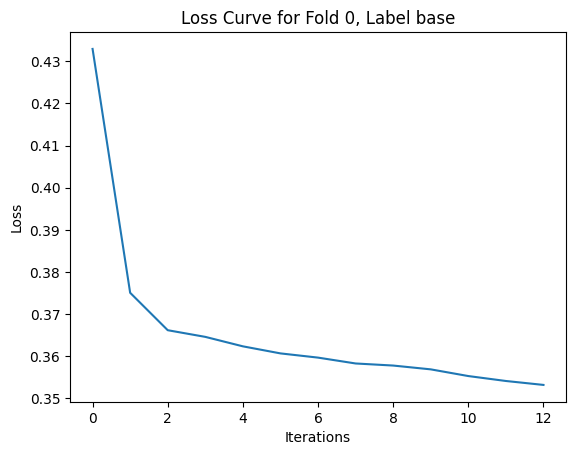

In [27]:
# Define testing cols 
cols = categorical_cols + personnel_cols + core_cols + ['variance_encoder'] + standard_cols + rolling_cols

# Define clip threshold for target
clip_threshold = 1.5

# Run base evaluation for personnel features
train_preds, test_preds, base_model = base_fold_eval(X_train_scaled, 
                                                     X_test_scaled, 
                                                     y_train.clip(-clip_threshold, clip_threshold), 
                                                     y_test.clip(-clip_threshold, clip_threshold), 
                                                     cols, 
                                                     0, 
                                                     "base")

# Model Training

In [105]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge 
from time import time
import warnings
import random # Used for Neutral Drift
warnings.filterwarnings('ignore', category=FutureWarning)

# --- DATA SETUP
cols = categorical_cols + personnel_cols + core_cols + ['variance_encoder'] + standard_cols + rolling_cols
X = df[cols].copy()
y = df['epa'].copy()

# --- DATA CLEANING FUNCTIONS ---
def _ensure_numeric_df(df):
    """Coerce object cols to numeric if possible, else to category codes. Fill NaN with 0."""
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == 'object':
            try:
                df[c] = pd.to_numeric(df[c], errors='coerce')
            except:
                df[c] = df[c].astype('category').cat.codes.replace(-1, np.nan)
        if df[c].dtype == 'bool':
            df[c] = df[c].astype(int)
    return df.fillna(0)

def _clean_y(y, fill_value=0.0, clip_abs=None):
    import numpy as _np
    y_arr = _np.asarray(y).astype(float).ravel()
    y_arr = _np.nan_to_num(y_arr, nan=fill_value, posinf=fill_value, neginf=-fill_value)
    if clip_abs is not None:
        y_arr = _np.clip(y_arr, -clip_abs, clip_abs)
    return y_arr

# --- HEURISTIC 3: HOMEOSTASIS (Variance Thresholding) ---
# Goal: Conserve "metabolic" resources by removing features that are too stable (low variance).
X_clean_initial = _ensure_numeric_df(X)
vt = VarianceThreshold(threshold=0.005) # Remove features with less than 1% variance
vt.fit(X_clean_initial)
homeostatic_features = X_clean_initial.columns[vt.get_support()]
print(f"Homeostasis: Dropped {len(X.columns) - len(homeostatic_features)} stable features.")
X = X[homeostatic_features].copy()

# --- CUSTOM XGBOOST LOSS FUNCTION (HARD-WALL CONSTRAINT) ---
def get_clipped_objective(clip_threshold, penalty_factor=100.0):
    """
    Returns a custom XGBoost objective function that enforces a hard-wall
    clip threshold on the predictions (Emulating strict environment constraints).
    """
    def custom_objective(y_true, y_pred):
        grad = y_pred - y_true
        hess = np.ones_like(y_true)

        low_clip_idx = y_pred < -clip_threshold
        grad[low_clip_idx] = -penalty_factor 
        hess[low_clip_idx] = penalty_factor / 10.0
        
        high_clip_idx = y_pred > clip_threshold
        grad[high_clip_idx] = penalty_factor
        hess[high_clip_idx] = penalty_factor / 10.0
        
        return grad, hess

    return custom_objective

# --- HYPERPARAMETERS ---
N_FOLDS = 4
N_ITERATIONS = 3
TOP_FEATURES_COUNT_BASE = 40 
MLP_ANTI_CORR_COUNT = 5
NEUTRAL_DRIFT_PERCENT = 0.05 # % of remaining features for Neutral Drift
TRAIN_ERROR_THRESHOLD = 1e-4
RANDOM_STATE = 999
HARD_WALL_PENALTY = 200.0 

# --- MODEL DEFINITIONS ---
xgb_params = {
    'n_estimators': 1000, 'learning_rate': 0.0025, 'max_depth': 6, 
    'colsample_bytree': 1.0, 'subsample': 1.0, 
    'reg_lambda': 80.0, 'reg_alpha': 0.5, 'gamma': 0.15, 'random_state': RANDOM_STATE, 
    'verbosity': 0, 'objective': 'reg:squarederror'
}

# --- INITIALIZATION ---
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
N = len(X)
true_y = _clean_y(y, fill_value=0.0, clip_abs=15)

all_oof_preds = {
    'XGB_OOF': np.zeros(N), 
    'MLP_OOF': np.zeros(N),
    'RIDGE_OOF': np.zeros(N)
}

# Store mlp diagnostics
loss_history = {}
test_mse = {}

# --- RECIPROCAL ITERATIVE PROCESS ---
print("="*80)
print(f"STARTING CO-EVOLUTIONARY ENSEMBLE PROCESS ({N_ITERATIONS} ITERATIONS)")
print("="*80)

for i in range(1, N_ITERATIONS + 1):
    print(f"\n--- ITERATION {i} ---")
    
    # --- 1. DYNAMIC TARGET CLIPPING (Curriculum Learning) ---
    y_positive = y[y > 0]
    max_quantile = i / N_ITERATIONS
    threshold = y_positive.quantile(max_quantile)
    y_clipped = y.clip(upper=threshold, lower=(-1*threshold))
    print(f" Clipping target y at \u00B1{threshold:.3f} (using {max_quantile:.2f} quantile).")

    # --- 2. DYNAMIC MLP CAPACITY & REGULARIZATION ---
    neuron_count = 200 + 24 * i
    mlp_params = {
        'hidden_layer_sizes': (neuron_count, neuron_count), 
        'alpha': 0,
        'tol': 1e-3,
        'learning_rate_init': 0.01,
        'max_iter': 10 + 50 * i, 
        'random_state': RANDOM_STATE,
        'verbose': False
    }
    print(f" MLP Capacity: ({neuron_count}, {neuron_count}), Max Iter: {mlp_params['max_iter']}")
    
    xgb_oof_iter = np.zeros(N)
    mlp_oof_iter = np.zeros(N)
    ridge_oof_iter = np.zeros(N)
    
    X_iter = X.copy()
    
    # --- 3. DYNAMIC FEATURE AUGMENTATION ---
    new_pred_features = []
    if i > 1:
        # Include OOF predictions from the previous best models as features
        xgb_feature_name = f'xgb_pred_{i-1}'
        mlp_feature_name = f'mlp_pred_{i-1}'
        ridge_feature_name = f'ridge_pred_{i-1}'
        
        X_iter[xgb_feature_name] = all_oof_preds['XGB_OOF']
        X_iter[mlp_feature_name] = all_oof_preds['MLP_OOF']
        X_iter[ridge_feature_name] = all_oof_preds['RIDGE_OOF']
        X_iter['ridge_confidence'] = np.abs(all_oof_preds['RIDGE_OOF'])
        
        new_pred_features = [xgb_feature_name, mlp_feature_name, ridge_feature_name, 'ridge_confidence']
        print(f" \u2192 Added {len(new_pred_features)} prediction features.")

    # --- XGBoost Configuration: Use the custom hard-wall objective ---
    xgb_params['objective'] = get_clipped_objective(threshold, penalty_factor=HARD_WALL_PENALTY)
    
    for fold_id, (train_idx, test_idx) in enumerate(kf.split(X_iter), 1):
        X_train, X_test = X_iter.iloc[train_idx], X_iter.iloc[test_idx]
        y_train, y_test = y_clipped.iloc[train_idx], y_clipped.iloc[test_idx]

        X_train_clean = _ensure_numeric_df(X_train)
        X_test_clean = _ensure_numeric_df(X_test)
        y_train_clean = _clean_y(y_train, fill_value=0.0, clip_abs=1e3)
        y_test_clean = _clean_y(y_test, fill_value=0.0, clip_abs=1e3)

        # --- 4. STEP: MODULARITY (Train Specialized XGB Experts) ---
        # Splitting the data based on 'play_type_run' (0=Pass, 1=Run)
        
        # Expert 1: XGBoost for PASS plays (0)
        mask_pass = X_train_clean['play_type_run'] == 0
        xgb_pass = XGBRegressor(**xgb_params)
        xgb_pass.fit(X_train_clean[mask_pass], y_train_clean[mask_pass])
        
        # Expert 2: XGBoost for RUN plays (1)
        mask_run = X_train_clean['play_type_run'] == 1
        xgb_run = XGBRegressor(**xgb_params)
        xgb_run.fit(X_train_clean[mask_run], y_train_clean[mask_run])
        
        # Combine expert predictions (Gate Network not needed, just combine)
        xgb_preds_train = np.zeros(len(X_train_clean))
        xgb_preds_test = np.zeros(len(X_test_clean))
        
        xgb_preds_train[mask_pass] = xgb_pass.predict(X_train_clean[mask_pass])
        xgb_preds_train[mask_run] = xgb_run.predict(X_train_clean[mask_run])

        # Predict test set using the appropriate expert
        xgb_preds_test[X_test_clean['play_type_run'] == 0] = xgb_pass.predict(X_test_clean[X_test_clean['play_type_run'] == 0])
        xgb_preds_test[X_test_clean['play_type_run'] == 1] = xgb_run.predict(X_test_clean[X_test_clean['play_type_run'] == 1])
        
        xgb_oof_iter[test_idx] = xgb_preds_test
        
        # Get feature importances from the dominant expert (Pass plays are typically more common/informative)
        feature_importances = pd.Series(xgb_pass.feature_importances_, index=X_train_clean.columns)
        
        # --- 5. STRATEGIC ANTI-CORRELATION + NEUTRAL DRIFT FEATURE SELECTION ---
        
        corr_series = X_train_clean.apply(
            lambda x: x.corr(pd.Series(xgb_preds_train, index=X_train_clean.index))
        ).abs().drop(new_pred_features, errors='ignore').dropna()
        
        # 5a. Get features least correlated with XGBoost prediction ("missed signal")
        anti_corr_features = corr_series.nsmallest(MLP_ANTI_CORR_COUNT).index.tolist()
        
        # 5b. Get the standard top features (for stability)
        top_features_base = feature_importances.drop(new_pred_features, errors='ignore').nlargest(TOP_FEATURES_COUNT_BASE).index.tolist()
        
        # 5c. NEUTRAL DRIFT: Select random features from the UNSELECTED pool.
        current_selection = set(new_pred_features + anti_corr_features + top_features_base)
        unselected_pool = list(set(X_train_clean.columns) - current_selection)
        
        drift_count = int(len(unselected_pool) * NEUTRAL_DRIFT_PERCENT)
        neutral_drift_features = random.sample(unselected_pool, min(drift_count, len(unselected_pool)))
        
        # Final Feature List for MLP
        top_features = list(set(list(current_selection) + neutral_drift_features))
        
        print(f" Fold {fold_id}: MLP Feats: {len(top_features)} (Anti-Corr: {MLP_ANTI_CORR_COUNT}, Drift: {len(neutral_drift_features)})")
        
        # 6. STEP: MLP (Interpolation for Residual Signal)
        scaler = StandardScaler() 
        X_train_scaled = scaler.fit_transform(X_train_clean[top_features])
        X_test_scaled = scaler.transform(X_test_clean[top_features])
        
        start_time = time()

        mlp = MLPRegressor(**mlp_params)
        mlp.fit(X_train_scaled, y_train_clean)

        elapsed_time = time() - start_time
        
        mlp_train_preds = mlp.predict(X_train_scaled)
        train_mse = mean_squared_error(y_train_clean, mlp_train_preds)
        mlp_preds_test = mlp.predict(X_test_scaled)

        # Store MLP diagnostics
        iteration_fold_key = f'Iter_{i}_Fold_{fold_id}'
        loss_history[iteration_fold_key] = mlp.loss_curve_
        test_mse[iteration_fold_key] = mean_squared_error(y_test_clean, mlp_preds_test).round(3)
        
        if train_mse < TRAIN_ERROR_THRESHOLD:
            # Success: Use the high-capacity interpolation result
            mlp_oof_iter[test_idx] = mlp_preds_test
            print(f" Fold {fold_id}: MLP SUCCESS (Train MSE: {train_mse:.8f}). Time: {elapsed_time:.4f} sec.")
        else:
            # Failure: Apply Soft Revert Governor (to prevent polluting the next iteration)
            BLENDING_WEIGHT = 0.75 
            safe_pred = (BLENDING_WEIGHT * mlp_preds_test) + ((1 - BLENDING_WEIGHT) * xgb_preds_test)
            mlp_oof_iter[test_idx] = safe_pred
            print(f" Fold {fold_id}: MLP FAILED DD (Train MSE: {train_mse:.8f}). Applying soft blend. Time: {elapsed_time:.4f} sec.")
            
        # 7. RIDGE prediction of XGB residuals (for next iteration's confidence feature)
        xgb_train_residuals = y_train_clean - xgb_preds_train

        # Use a reduced set of features for the Ridge prediction (for added regularization/stability)
        X_ridge_train = X_train_clean[list(set(new_pred_features + top_features_base))].replace([np.inf, -np.inf], np.nan).fillna(0).astype(float)
        X_ridge_test = X_test_clean[list(set(new_pred_features + top_features_base))].replace([np.inf, -np.inf], np.nan).fillna(0).astype(float)

        ridge = Ridge(alpha=20.0)
        ridge.fit(X_ridge_train, xgb_train_residuals) 

        ridge_preds_test = ridge.predict(X_ridge_test)
        ridge_oof_iter[test_idx] = ridge_preds_test

    # 8. Aggregation and Feature Update
    all_oof_preds['XGB_OOF'] = xgb_oof_iter
    all_oof_preds['MLP_OOF'] = mlp_oof_iter
    all_oof_preds['RIDGE_OOF'] = ridge_oof_iter

    # 9. FINAL META-LEARNER TRAINING (Optimal Weights - The Genome)
    X_meta = np.vstack([
        all_oof_preds['XGB_OOF'],
        all_oof_preds['MLP_OOF'],
        all_oof_preds['RIDGE_OOF']
    ]).T
    y_meta = true_y 

    meta_model = Ridge(alpha=10.0) 
    meta_model.fit(X_meta, y_meta)
    final_ensemble_oof = meta_model.predict(X_meta)

    xgb_r2 = r2_score(true_y, all_oof_preds['XGB_OOF'])
    mlp_r2 = r2_score(true_y, all_oof_preds['MLP_OOF'])
    ensemble_r2 = r2_score(true_y, final_ensemble_oof)
    
    print(f"\nITERATION {i} RESULTS (OOF R^2):")
    print(f" \u2022 XGBoost (Modular Hard-Wall): {xgb_r2:.4f}")
    print(f" \u2022 MLP (Anti-Corr + Drift): {mlp_r2:.4f}")
    print(f" \u2022 META ENSEMBLE: {ensemble_r2:.4f}")

print("\n" + "="*80)
print(f"PROCESS COMPLETE. FINAL META ENSEMBLE R^2: {ensemble_r2:.4f}")
print("="*80)

Homeostasis: Dropped 29 stable features.
STARTING CO-EVOLUTIONARY ENSEMBLE PROCESS (3 ITERATIONS)

--- ITERATION 1 ---
 Clipping target y at ±0.552 (using 0.33 quantile).
 MLP Capacity: (224, 224), Max Iter: 60
 Fold 1: MLP Feats: 49 (Anti-Corr: 5, Drift: 4)
 Fold 1: MLP FAILED DD (Train MSE: 0.21282964). Applying soft blend. Time: 29.7725 sec.
 Fold 2: MLP Feats: 49 (Anti-Corr: 5, Drift: 4)
 Fold 2: MLP FAILED DD (Train MSE: 0.21464786). Applying soft blend. Time: 30.3240 sec.
 Fold 3: MLP Feats: 48 (Anti-Corr: 5, Drift: 4)
 Fold 3: MLP FAILED DD (Train MSE: 0.21261190). Applying soft blend. Time: 29.8896 sec.
 Fold 4: MLP Feats: 48 (Anti-Corr: 5, Drift: 4)
 Fold 4: MLP FAILED DD (Train MSE: 0.21641057). Applying soft blend. Time: 29.9550 sec.

ITERATION 1 RESULTS (OOF R^2):
 • XGBoost (Modular Hard-Wall): 0.0262
 • MLP (Anti-Corr + Drift): 0.0148
 • META ENSEMBLE: 0.0452

--- ITERATION 2 ---
 Clipping target y at ±1.240 (using 0.67 quantile).
 MLP Capacity: (248, 248), Max Iter: 110


c:\Users\Jack\Documents\GitHub\FFInsights\code\.conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (160) reached and the optimization hasn't converged yet.
  warnings.warn(


 Fold 3: MLP FAILED DD (Train MSE: 1.48949630). Applying soft blend. Time: 583.8241 sec.
 Fold 4: MLP Feats: 51 (Anti-Corr: 5, Drift: 4)
 Fold 4: MLP FAILED DD (Train MSE: 1.74600629). Applying soft blend. Time: 122.0077 sec.

ITERATION 3 RESULTS (OOF R^2):
 • XGBoost (Modular Hard-Wall): 0.0831
 • MLP (Anti-Corr + Drift): 0.0505
 • META ENSEMBLE: 0.0861

PROCESS COMPLETE. FINAL META ENSEMBLE R^2: 0.0861


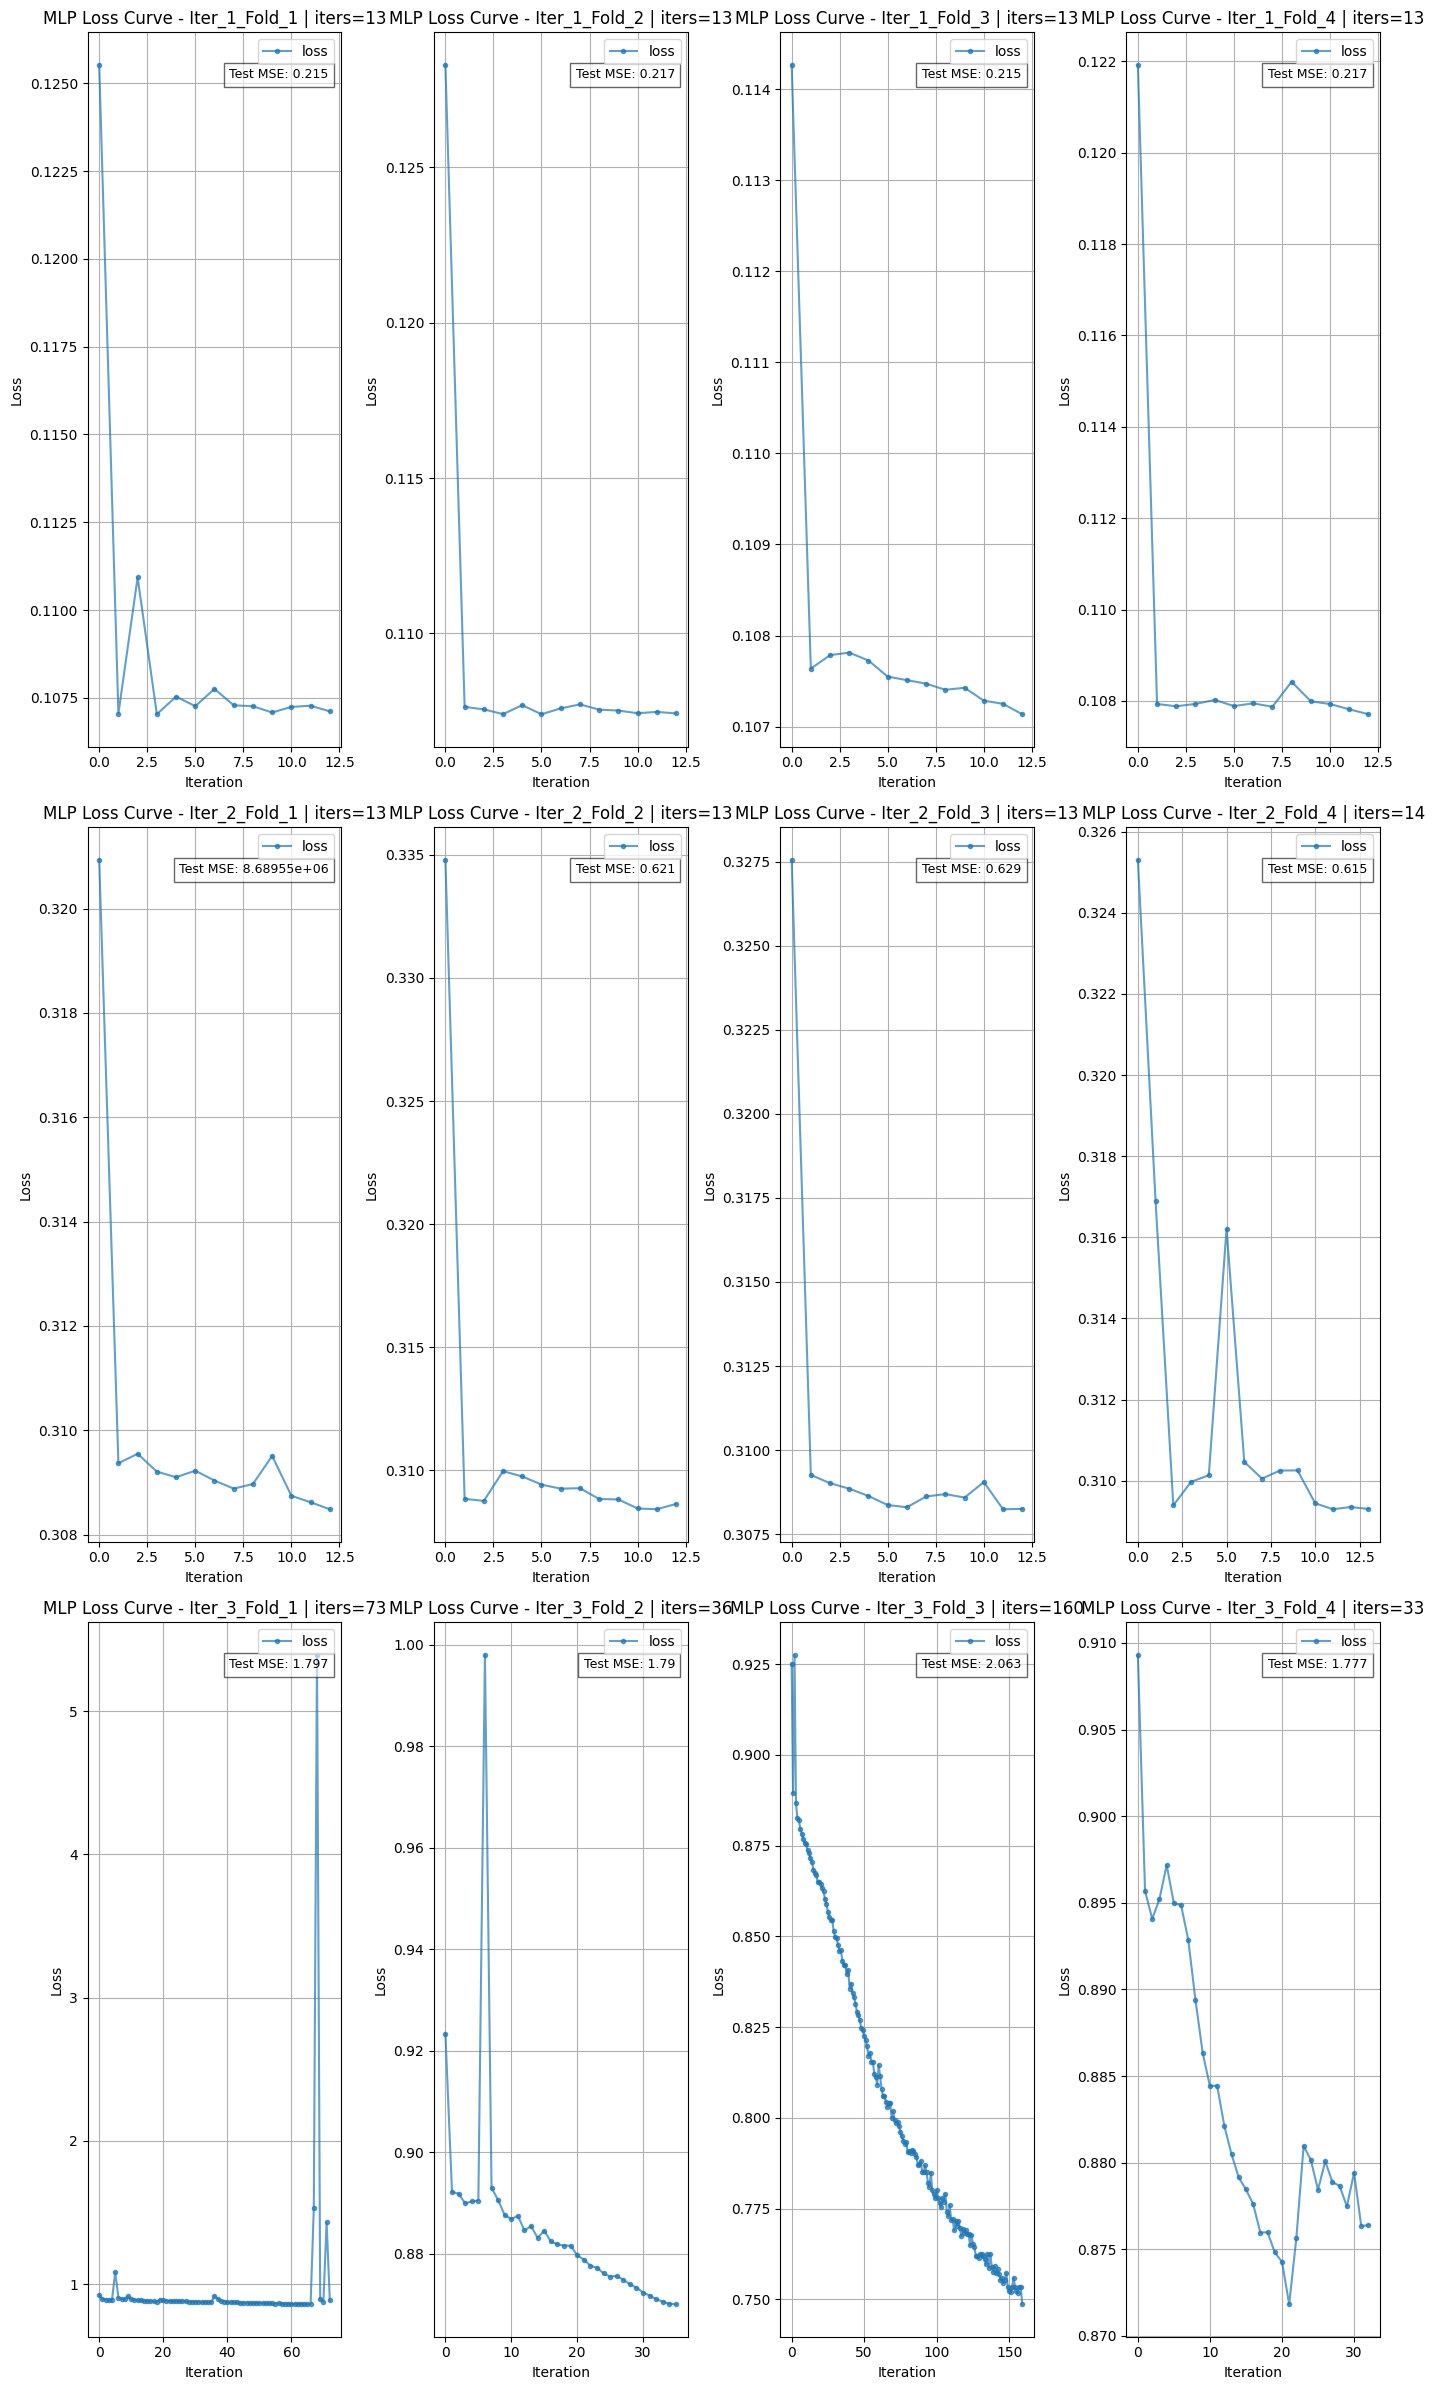

In [107]:
# Plot the subplots of mlp loss for each iteration and fold (robust)
import matplotlib.pyplot as plt
import numpy as np

if not loss_history:
    print("loss_history is empty")
else:
    keys = list(loss_history.keys())
    num_plots = len(keys)
    plot_rows = (num_plots + N_FOLDS - 1) // N_FOLDS  # Calculate required rows
    fig, axes = plt.subplots(nrows=plot_rows, ncols=N_FOLDS, figsize=(14, 2 * num_plots), squeeze=False)
    axes = axes.ravel()

    for ax, k in zip(axes, keys):
        loss_curve = loss_history.get(k) or []
        if len(loss_curve) == 0:
            ax.text(0.5, 0.5, "no loss_curve available", ha='center', va='center')
            ax.set_title(f'MLP Loss Curve - {k} (empty)')
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Loss')
            continue

        ax.plot(loss_curve, marker='.', alpha=0.7, label='loss')

        ax.set_title(f'MLP Loss Curve - {k} | iters={len(loss_curve)}')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Loss')
        ax.grid(True)
        ax.legend(loc='best')

        # Add label for test MSE if available
        test_mse_value = test_mse.get(k, None)
        if test_mse_value is not None:
            ax.text(0.95, 0.95, f'Test MSE: {test_mse_value:.6g}', 
                    horizontalalignment='right', verticalalignment='top', 
                    transform=ax.transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.6))
            

    plt.tight_layout()
    plt.show()

In [108]:
for i in range(1, N_ITERATIONS + 1):
    print(f"Iteration {i}:")
    print(1.5 / (i**5))

Iteration 1:
1.5
Iteration 2:
0.046875
Iteration 3:
0.006172839506172839


c:\Users\Jack\Documents\GitHub\FFInsights\code\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


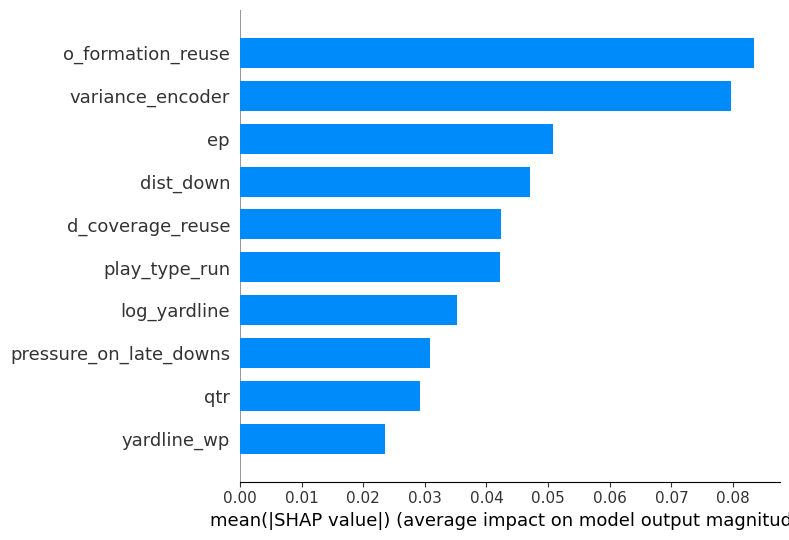

In [7]:
import shap
explainer = shap.TreeExplainer(base_model)
shap_values = explainer.shap_values(X_test_scaled[cols])

# Plot SHAP values
shap.summary_plot(shap_values, features=X_test_scaled[cols], feature_names=cols, plot_type='bar', max_display=10)

In [ ]:
highest_shap_features= ['o_formation_reuse', 'variance_encoder', 'ep', 'dist_down', 'd_coverage_reuse', 'play_type_run', 'log_yardline', 'pressure_on_late_downs', 'qtr', 'yardline_wp', 'xpass_receivers', 'prev_yards_gain', 'temp', 'xpass', 'yardline_per_sec']

In [8]:
# Highest shap values
highest_shap_indices = np.argsort(np.abs(shap_values).mean(axis=0))[::-1]
num_features_to_show = 15  # Change this to show more features
highest_shap_features = [cols[i] for i in highest_shap_indices[:num_features_to_show]]
print("Highest SHAP features:", highest_shap_features)

lowest_shap_indices = np.argsort(np.abs(shap_values).mean(axis=0))[:num_features_to_show]
lowest_shap_features = [cols[i] for i in lowest_shap_indices]
print("Lowest SHAP features:", lowest_shap_features)

Highest SHAP features: ['o_formation_reuse', 'variance_encoder', 'ep', 'dist_down', 'd_coverage_reuse', 'play_type_run', 'log_yardline', 'pressure_on_late_downs', 'qtr', 'yardline_wp', 'xpass_receivers', 'prev_yards_gain', 'temp', 'xpass', 'yardline_per_sec']
Lowest SHAP features: ['yardline_100', 'ydstogo', 'critical_down', 'defense_coverage_type_PREVENT', 'soft_defense', 'two_min_warn', 'defense_coverage_type_COVER_0', 'win_formation', 'wr_count', 'surface_matrixturf', 'roof_open', 'defense_coverage_type_COVER_4', 'rb_count', 'blocker_to_rusher_ratio', 'defense_coverage_type_COVER_6']


In [23]:
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

def poly_base_top_features(
    X_train_scaled, X_test_scaled, y_train, y_test, feature_cols, fold_id, label, top_n=5, degree=2
):
    """
    Fit polynomial regression on a feature group, print metrics, and return top N features' DataFrames.
    Returns:
        top_features_train: DataFrame of top N features (train)
        top_features_test: DataFrame of top N features (test)
    """
    poly = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)
    base_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.30, max_depth=45, reg_lambda=0.01, gamma=0.001)

    X_train_poly = poly.fit_transform(X_train_scaled[feature_cols])
    X_test_poly = poly.transform(X_test_scaled[feature_cols])
    feature_names = poly.get_feature_names_out(feature_cols)

    # Rolling Average columns if in feature_cols
    check_cols = ['variance_encoder', 'dist_down', 'play_type_run', 'pressure_on_late_downs',  'xpass_receivers', 'temp', 'xpass']
    for col in check_cols:
        if col in feature_cols:
            rolling_col_name = f'rolling_avg_{col}'
            X_train_poly = pd.DataFrame(X_train_poly, columns=feature_names).assign(**{rolling_col_name: X_train_scaled[col].rolling(window=60, min_periods=1).mean().values})
            X_test_poly = pd.DataFrame(X_test_poly, columns=feature_names).assign(**{rolling_col_name: X_test_scaled[col].rolling(window=60, min_periods=1).mean().values})
            feature_names = X_train_poly.columns.tolist()
            X_train_poly = X_train_poly.values
            X_test_poly = X_test_poly.values

    base_model.fit(X_train_poly, y_train)
    preds = base_model.predict(X_test_poly)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    train_preds = base_model.predict(X_train_poly)
    train_mse = mean_squared_error(y_train, train_preds)
    train_r2 = r2_score(y_train, train_preds)
    print(f"Fold {fold_id} {label} Polynomial   Test  MSE: {mse:.3f}, Test R^2: {r2:.3f} | Train MSE: {train_mse:.3f}, Train R^2: {train_r2:.3f}")

    # Get feature importances (importance is always positive)
    importances = pd.Series(base_model.feature_importances_, index=feature_names)
    top_feature_names = importances.sort_values(ascending=False).head(top_n).index.tolist()

    # Create DataFrames of just those features
    top_features_train = pd.DataFrame(X_train_poly, columns=feature_names, index=X_train_scaled.index)[top_feature_names]
    top_features_test  = pd.DataFrame(X_test_poly,  columns=feature_names, index=X_test_scaled.index)[top_feature_names]

    # Add predictions to the DataFrames
    top_features_train[label+'_predictions'] = train_preds
    top_features_test[label+'_predictions'] = preds

    return top_features_train, top_features_test

In [ ]:
# Run polynomial features and get top features
top_features_train, top_features_test = poly_base_top_features(
    X_train_scaled, X_test_scaled, y_train, y_test, highest_shap_features, 0, "Top", top_n=5, degree=2
)

XGBoostError: [13:21:05] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\io.h:232: bad_malloc: Failed to allocate 23775878304 bytes.

In [ ]:
def poly_base_top_features(
    X_train_scaled, X_test_scaled, y_train, y_test, feature_cols, fold_id, label, top_n=5, degree=2
):
    """
    Fit polynomial features + MLP on a feature group, print metrics, and return top N features' DataFrames.
    Returns:
        top_features_train: DataFrame of top N features (train)
        top_features_test: DataFrame of top N features (test)
    """
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.neural_network import MLPRegressor
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.inspection import permutation_importance
    import pandas as pd
    import numpy as np

    poly = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)

    # Build polynomial features
    X_train_poly = poly.fit_transform(X_train_scaled[feature_cols])
    X_test_poly = poly.transform(X_test_scaled[feature_cols])
    feature_names = list(poly.get_feature_names_out(feature_cols))

    # Rolling Average columns if in feature_cols (append as new columns)
    check_cols = ['variance_encoder', 'dist_down', 'play_type_run', 'pressure_on_late_downs', 'xpass_receivers', 'temp', 'xpass']
    if any(col in feature_cols for col in check_cols):
        X_train_poly_df = pd.DataFrame(X_train_poly, columns=feature_names, index=X_train_scaled.index)
        X_test_poly_df  = pd.DataFrame(X_test_poly,  columns=feature_names, index=X_test_scaled.index)
        for col in check_cols:
            if col in feature_cols:
                rolling_col_name = f'rolling_avg_{col}'
                # preserve alignment by using the passed X_train_scaled/X_test_scaled indices
                X_train_poly_df[rolling_col_name] = X_train_scaled[col].rolling(window=60, min_periods=1).mean().values
                X_test_poly_df[rolling_col_name]  = X_test_scaled[col].rolling(window=60, min_periods=1).mean().values
        feature_names = X_train_poly_df.columns.tolist()
        X_train_poly = X_train_poly_df.values
        X_test_poly  = X_test_poly_df.values
    else:
        # ensure DataFrame versions exist for later indexing
        X_train_poly_df = pd.DataFrame(X_train_poly, columns=feature_names, index=X_train_scaled.index)
        X_test_poly_df  = pd.DataFrame(X_test_poly,  columns=feature_names, index=X_test_scaled.index)

    # MLP regressor
    mlp = MLPRegressor(
        hidden_layer_sizes=(1000, 1000, 500),
        alpha=0.01,
        tol=0.0,
        learning_rate_init=0.025,
        max_iter=5000,
        random_state=999,
        verbose=False
    )

    mlp.fit(X_train_poly, y_train)

    # Predictions & metrics
    preds = mlp.predict(X_test_poly)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    train_preds = mlp.predict(X_train_poly)
    train_mse = mean_squared_error(y_train, train_preds)
    train_r2 = r2_score(y_train, train_preds)
    print(f"Fold {fold_id} {label} Polynomial-MLP   Test  MSE: {mse:.3f}, Test R^2: {r2:.3f} | Train MSE: {train_mse:.3f}, Train R^2: {train_r2:.3f}")

    return None, None

In [49]:
poly_base_top_features(
    X_train_scaled, X_test_scaled, y_train, y_test, highest_shap_features, 0, "Top", top_n=5, degree=2
)

Fold 0 Top Polynomial-MLP   Test  MSE: 1.938, Test R^2: 0.006 | Train MSE: 1.907, Train R^2: 0.007


(None, None)

# Investigate Errors

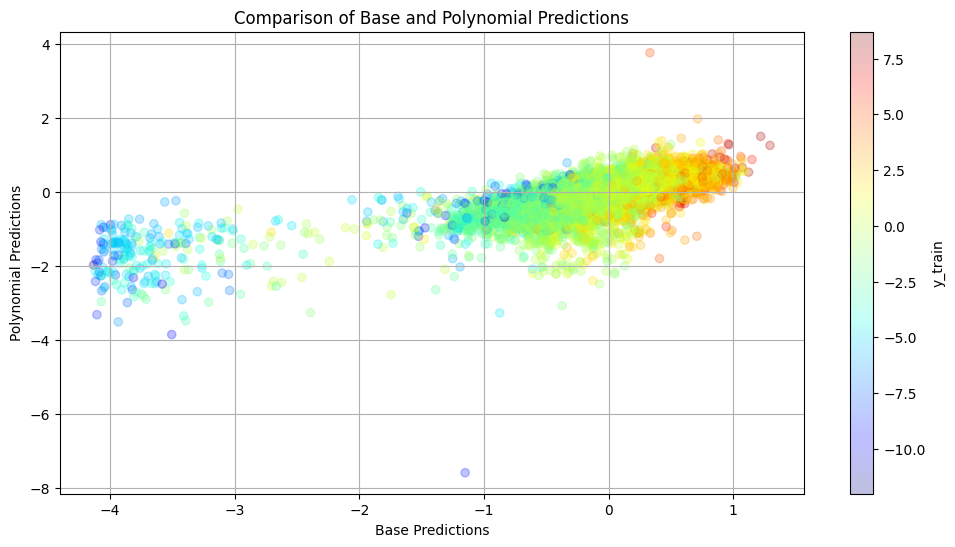

In [15]:
# Compare base predictions against polynomial predictions
plt.figure(figsize=(12, 6))
plt.scatter(
    x=train_preds,
    y=top_features_train['Top_predictions'],
    c=y_train,
    cmap='jet',
    alpha=0.25,
)
plt.xlabel("Base Predictions")
plt.ylabel("Polynomial Predictions")
plt.title("Comparison of Base and Polynomial Predictions")
plt.colorbar(label='y_train')  # Show color scale
plt.grid()
plt.show()

Top features distinguishing hardest vs easiest to predict:
xpass                          | Mean diff: -0.047 | p-value:  4.32e-70
xpass_receivers                | Mean diff: -0.195 | p-value:  5.28e-67
down                           | Mean diff: -0.128 | p-value:  1.95e-41
qb_scramble                    | Mean diff:  0.021 | p-value:  4.18e-36
qb_dropback                    | Mean diff: -0.062 | p-value:  2.32e-35
db_count                       | Mean diff: -0.078 | p-value:  3.39e-22
ydstogo                        | Mean diff: -0.413 | p-value:  2.82e-21
box_minus_rushers              | Mean diff:  0.127 | p-value:  7.67e-21
shotgun                        | Mean diff: -0.046 | p-value:  5.82e-19
defensive_back_density         | Mean diff: -0.024 | p-value:  4.84e-18
Residual Model MSE: 1.847
Residual Model R^2: 0.004


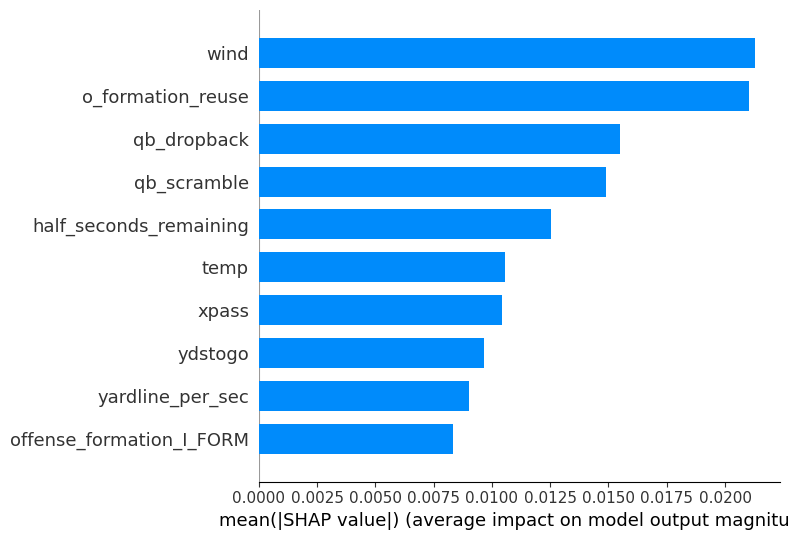

Highest SHAP features: ['wind', 'o_formation_reuse', 'qb_dropback', 'qb_scramble', 'half_seconds_remaining', 'temp', 'xpass', 'ydstogo', 'yardline_per_sec', 'offense_formation_I_FORM', 'xpass_receivers', 'variance_encoder', 'week', 'box_minus_rushers', 'front_density']


In [16]:
# Check index alignment
assert all(train_preds.index == top_features_train.index)
assert all(train_preds.index == y_train.index)

# Average the predictions between base and polynomial
avg_train_preds = (train_preds['base_predictions'] + top_features_train['Top_predictions']) / 2
avg_test_preds = (test_preds['base_predictions'] + top_features_test['Top_predictions']) / 2

# Find residuals between average pred and observed values
train_residuals = y_train - avg_train_preds
test_residuals = y_test - avg_test_preds

# Filter for top 25 percent of predictions
top_33_percentile = train_residuals[train_residuals >= train_residuals.quantile(0.67)]
bottom_33_percentile = train_residuals[train_residuals <= train_residuals.quantile(0.33)]

# Apply masks to training data
X_train_top = X_train.loc[top_33_percentile.index]
X_train_bottom = X_train.loc[bottom_33_percentile.index]

# Compare features
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Only compare numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

feature_diffs = []
for col in numeric_cols:
    top_vals = X_train_top[col].dropna()
    bottom_vals = X_train_bottom[col].dropna()
    mean_diff = top_vals.mean() - bottom_vals.mean()
    t_stat, p_val = ttest_ind(top_vals, bottom_vals, equal_var=False)
    feature_diffs.append((col, mean_diff, p_val))

feature_diffs = sorted(feature_diffs, key=lambda x: x[2])

print("Top features distinguishing hardest vs easiest to predict:")
for col, diff, p in feature_diffs[:10]:
    print(f"{col:30s} | Mean diff: {diff: .3f} | p-value: {p: .3g}")

# Fit xgboost on the residuals
model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.025, max_depth=10, reg_lambda=10.0, gamma=1.0)
train_residuals = pd.DataFrame(train_residuals, columns=['residuals'], index=X_train_scaled.index).fillna(0)
test_residuals = pd.DataFrame(test_residuals, columns=['residuals'], index=X_test_scaled.index).fillna(0)
model.fit(X_train_scaled, train_residuals)
mse = mean_squared_error(test_residuals, model.predict(X_test_scaled))
print(f"Residual Model MSE: {mse:.3f}")
rsquared = r2_score(test_residuals, model.predict(X_test_scaled))
print(f"Residual Model R^2: {rsquared:.3f}")

# Run shap test on residual model
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP values
shap.summary_plot(shap_values, features=X_test_scaled, feature_names=X_test_scaled.columns, plot_type='bar', max_display=10)

# Highest shap values
highest_shap_indices = np.argsort(np.abs(shap_values).mean(axis=0))[::-1]
num_features_to_show = 15  # Change this to show more features
highest_shap_features = [X_test_scaled.columns[i] for i in highest_shap_indices[:num_features_to_show]]
print("Highest SHAP features:", highest_shap_features)

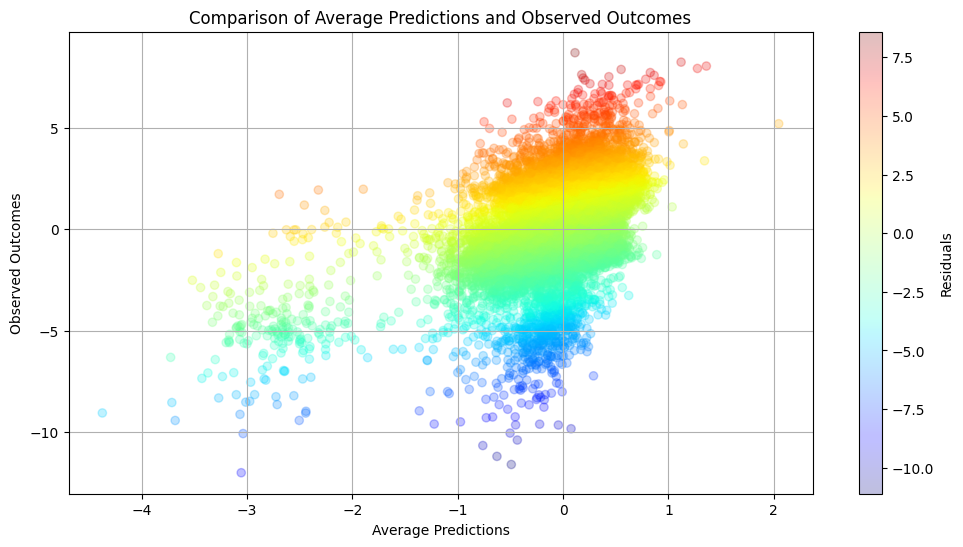

In [17]:
# Compare base predictions against polynomial predictions
# train_residuals = y_train - avg_train_preds
train_residuals = train_residuals.squeeze()
plt.figure(figsize=(12, 6))
plt.scatter(
    x=avg_train_preds,
    y=y_train,
    c=train_residuals,
    cmap='jet',
    alpha=0.25,
)
plt.xlabel("Average Predictions")
plt.ylabel("Observed Outcomes")
plt.title("Comparison of Average Predictions and Observed Outcomes")
plt.colorbar(label='Residuals')  # Show color scale
plt.grid()
plt.show()

# Make & Save Predictions

In [23]:
import nfl_data_py as nfl

# Define the years to import
yrs = range(2015, 2024)
#yrs = 2022

# Play-by-Play Data
pbp_data = nfl.import_pbp_data(years=yrs)

df, categorical_cols, standard_cols, core_cols, personnel_cols = feature_engineering(pbp_data)

2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [27]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Example: your raw features and target
X = df.drop(columns=['epa', 'game_id', 'play_id']).copy()
y = df['epa'].copy()

# Create fold splits
kf = KFold(n_splits=3, shuffle=True, random_state=999)

# Store fold indices for later reuse
folds = []
for train_idx, test_idx in kf.split(X):
    folds.append((train_idx, test_idx))
    
oof_preds = []

for fold_id, (train_idx, test_idx) in enumerate(folds):
    # Keep the original ids for later
    train_ids = df.iloc[train_idx][['game_id', 'play_id', 'epa']]
    test_ids = df.iloc[test_idx][['game_id', 'play_id', 'epa']]

    # Apply scaling only to training set
    scaler = StandardScaler()
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Remove infinities and NaNs
    X_train = X_train.replace([np.inf, -np.inf], 0)
    X_test = X_test.replace([np.inf, -np.inf], 0)

    # Target encoding
    group_collection = ['down', 'play_type_run', 'defense_coverage_type_COVER_1', 'defense_coverage_type_COVER_0', 'defense_man_zone_type_ZONE_COVERAGE', 'offense_formation_SINGLEBACK', 
                    'offense_formation_SHOTGUN', 'd_coverage_reuse']
    # Build group means on training data only
    group_means = df.iloc[train_idx].groupby(group_collection)['epa'].std().reset_index()
    group_means = group_means.rename(columns={'epa': 'variance_encoder'})

    # Merge into train
    X_train = X_train.merge(
        group_means, 
        on=group_collection, 
        how='left'
    )
    # Merge into test
    X_test = X_test.merge(
        group_means, 
        on=group_collection, 
        how='left'
    )
    # Create a new Series with the correct index for assignment
    variance_encoder_series = pd.concat([
        pd.Series(X_train['variance_encoder'].values, index=train_idx),
        pd.Series(X_test['variance_encoder'].values, index=test_idx)
    ])

    # Assign to df using .loc to align by index
    df['variance_encoder'] = variance_encoder_series
    df['variance_encoder'] = df['variance_encoder'].fillna(0)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame for consistency
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    X_train_scaled = X_train_scaled.fillna(0)
    X_test_scaled = X_test_scaled.fillna(0)
    y_train = y_train.fillna(0)
    y_test = y_test.fillna(0)

    #X_train_scaled = X_train_scaled.reset_index(drop=True)
    #y_train = y_train.reset_index(drop=True)
    #X_test_scaled = X_test_scaled.reset_index(drop=True)
    #y_test = y_test.reset_index(drop=True)

    # Define testing cols
    cols = categorical_cols + personnel_cols + core_cols + ['variance_encoder'] + standard_cols

    # Define base predictions
    base_train_preds, base_test_preds, base_model = base_fold_eval(X_train_scaled, X_test_scaled, y_train, y_test, cols, fold_id, "Base")

    base_test_preds = pd.DataFrame({'Base_predictions': np.ravel(base_test_preds)}, index=test_idx)

    Highest_SHAP_features = ['o_formation_reuse', 'variance_encoder', 'ep', 'dist_down', 'd_coverage_reuse', 'play_type_run', 'log_yardline', 
                         'pressure_on_late_downs', 'qtr', 'yardline_wp', 'xpass_receivers', 'prev_yards_gain', 'temp', 'xpass', 'yardline_per_sec']

    # Use iloc since test_idx is positional, not labels
    test_ids = df.iloc[test_idx][['game_id', 'play_id', 'epa'] + Highest_SHAP_features]
    base_test_preds.index = test_ids.index  # force alignment
    base_test_preds = test_ids.join(base_test_preds)

    oof_preds.append(base_test_preds)

# Combine folds into one OOF dataframe
oof_preds = pd.concat(oof_preds).sort_index()

# Shrink predictions by rsquared
rsquared = r2_score(oof_preds['epa'].fillna(0), oof_preds['Base_predictions'].fillna(0))
oof_preds['shrinked_preds'] = oof_preds['Base_predictions'] * rsquared

# Define residuals
oof_preds['residual_epa'] = oof_preds['epa'] - oof_preds['shrinked_preds']

# Save to C:\Users\Jack\Documents\GitHub\FFInsights
oof_preds.to_csv(r'C:\Users\Jack\Documents\GitHub\FFInsights\context_preds.csv', index=False)

Fold 0 Base Base       Test MSE: 1.800, Test R^2: 0.062 | Train MSE: 1.581, Train R^2: 0.176
Fold 1 Base Base       Test MSE: 1.801, Test R^2: 0.058 | Train MSE: 1.605, Train R^2: 0.164
Fold 2 Base Base       Test MSE: 1.810, Test R^2: 0.058 | Train MSE: 1.598, Train R^2: 0.166


In [21]:
df.columns

Index(['defenders_in_box', 'ydstogo', 'half_seconds_remaining', 'wp', 'ep',
       'week', 'down', 'number_of_pass_rushers', 'yardline_100', 'xpass',
       ...
       'surface_a_turf', 'surface_astroplay', 'surface_astroturf',
       'surface_fieldturf', 'surface_grass', 'surface_grass ',
       'surface_matrixturf', 'surface_sportturf', 'variance_encoder_x',
       'variance_encoder_y'],
      dtype='object', length=107)

In [121]:
oof_preds.describe()

,play_id,epa,Base_predictions,shrinked_preds,residual_epa
count,309149.000000,309148.000000,309149.000000,309149.000000,309148.000000
mean,2097.117676,-0.002919,-0.003241,-0.000193,-0.002726
std,1230.788696,1.384917,0.360245,0.021462,1.379824
min,36.000000,-13.584859,-5.221240,-0.311064,-13.585257
25%,1026.000000,-0.625574,-0.127756,-0.007611,-0.626429
50%,2102.000000,-0.178753,0.011235,0.000669,-0.178017
75%,3135.000000,0.708110,0.166134,0.009898,0.705532
max,5899.000000,8.882384,1.805925,0.107591,8.871137


In [118]:
# merge play_type back to oof_preds
oof_preds = oof_preds.merge(pbp_data[['game_id', 'play_id', 'play_type']], on=['game_id', 'play_id'], how='left')
oof_preds.head(10)

,game_id,play_id,epa,Base_predictions,shrinked_preds,residual_epa,play_type
0,2017_01_ARI_DET,73.0,0.025196,0.052571,0.003806,0.021389,pass
1,2017_01_ARI_DET,97.0,-0.362216,0.022437,0.001625,-0.363841,run
2,2017_01_ARI_DET,118.0,1.880075,-0.372530,-0.026974,1.907048,pass
3,2017_01_ARI_DET,153.0,-0.948572,-0.331560,-0.024007,-0.924565,run
4,2017_01_ARI_DET,174.0,-0.913345,0.111365,0.008064,-0.921409,pass
5,2017_01_ARI_DET,207.0,-4.785328,-0.380542,-0.027554,-4.757775,pass
6,2017_01_ARI_DET,233.0,0.051485,-0.178605,-0.012932,0.064417,run
7,2017_01_ARI_DET,254.0,-11.603202,-0.305249,-0.022102,-11.581100,pass
8,2017_01_ARI_DET,316.0,-0.616428,-0.396459,-0.028706,-0.587722,run
9,2017_01_ARI_DET,337.0,-0.546338,-0.376297,-0.027246,-0.519092,pass


In [ ]:
context_preds = pd.read_csv(r'C:\Users\Jack\Documents\GitHub\FFInsights\context_preds.csv')
context_preds.head(10)

,game_id,play_id,epa,Base_predictions,shrinked_preds,residual_epa
0,2015_01_BAL_DEN,51.0,-0.337139,-0.132337,0.002166,-0.339304
1,2015_01_BAL_DEN,75.0,-0.262481,NaN,NaN,NaN
2,2015_01_BAL_DEN,96.0,1.661242,-0.133492,0.002185,1.659057
3,2015_01_BAL_DEN,120.0,-0.518931,NaN,NaN,NaN
4,2015_01_BAL_DEN,141.0,-0.449598,NaN,NaN,NaN


In [118]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Example: your raw features and target
X = df.drop(columns=['epa', 'game_id', 'play_id']).copy()
y = df['epa'].copy()

# Clip y
#y = y.clip(lower=-1, upper=1)

# Create fold splits
kf = KFold(n_splits=2, shuffle=True, random_state=999)

# Store fold indices for later reuse
folds = []
for train_idx, test_idx in kf.split(X):
    folds.append((train_idx, test_idx))
    
oof_preds = []

for fold_id, (train_idx, test_idx) in enumerate(folds):
    # Apply scaling only to training set
    scaler = StandardScaler()
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Remove infinities and NaNs
    X_train = X_train.replace([np.inf, -np.inf], 0)
    X_test = X_test.replace([np.inf, -np.inf], 0)

    # Target encoding
    group_collection = ['down', 'play_type_run', 'defense_coverage_type_COVER_1', 'defense_coverage_type_COVER_0', 'defense_man_zone_type_ZONE_COVERAGE', 'offense_formation_SINGLEBACK', 
                    'offense_formation_SHOTGUN']
    # Build group means on training data only
    group_means = df.iloc[train_idx].groupby(group_collection)['epa'].std().reset_index()
    group_means = group_means.rename(columns={'epa': 'variance_encoder'})
    # Merge into train
    X_train = X_train.merge(
        group_means, 
        on=group_collection, 
        how='left'
    )
    # Merge into test
    X_test = X_test.merge(
        group_means, 
        on=group_collection, 
        how='left'
    )

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame for consistency
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    X_train_scaled = X_train_scaled.fillna(0)
    X_test_scaled = X_test_scaled.fillna(0)
    y_train = y_train.fillna(0)
    y_test = y_test.fillna(0)

    X_train_scaled = X_train_scaled.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test_scaled = X_test_scaled.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Define testing cols
    cols = categorical_cols + personnel_cols + core_cols + ['variance_encoder'] + standard_cols

    # Define base predictions
    base_train_preds, base_test_preds, base_model = base_fold_eval(X_train_scaled, X_test_scaled, y_train, y_test, cols, fold_id, "Base")

    # Highest shap values
    import shap
    explainer = shap.TreeExplainer(base_model)
    shap_values = explainer.shap_values(X_test_scaled[cols])
    highest_shap_indices = np.argsort(np.abs(shap_values).mean(axis=0))[::-1]
    num_features_to_show = 20
    highest_shap_features = [cols[i] for i in highest_shap_indices[:num_features_to_show]]

    # Apply polynomial ridge to each collection of features
    poly_features_train, poly_features_test = poly_base_top_features(
        X_train_scaled, X_test_scaled, y_train, y_test, highest_shap_features, fold_id, "Poly", top_n=10
    )

    # ----------- COMBINE ALL SELECTED FEATURES ------------
    final_X_train = pd.concat([
        poly_features_train,
        base_train_preds
    ], axis=1)

    final_X_test = pd.concat([
        poly_features_test,
        base_test_preds
    ], axis=1)

    # Remove duplicate columns if any
    final_X_train = final_X_train.loc[:, ~final_X_train.columns.duplicated()]
    final_X_test = final_X_test.loc[:, ~final_X_test.columns.duplicated()]

    # Convert y to DataFrame for consistency
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
    y_train = y_train.values.flatten()
    y_test = y_test.values.flatten()

    # Run XGBoost
    import xgboost as xgb
    from sklearn.neural_network import MLPRegressor
    xgb_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.005, max_depth=5, reg_lambda=100000.0, gamma=5.10)
    xgb_model = Ridge(alpha=12000.0)
    xgb_model = MLPRegressor(hidden_layer_sizes=(5, 5), max_iter=1000, alpha=10.01, tol=1)
    xgb_model.fit(final_X_train, y_train)
    fold_oof_preds = xgb_model.predict(final_X_test)
    oof_preds.append(fold_oof_preds)
    mse_xgb = mean_squared_error(y_test, fold_oof_preds)
    r2_xgb = r2_score(y_test, fold_oof_preds)
    train_preds = xgb_model.predict(final_X_train)
    train_mse_xgb = mean_squared_error(y_train, train_preds)
    train_r2_xgb = r2_score(y_train, train_preds)
    print(f"Fold {fold_id} --- FINAL MSE: {mse_xgb:.3f}, R^2: {r2_xgb:.3f} | Train MSE: {train_mse_xgb:.3f}, Train R^2: {train_r2_xgb:.3f}")

Fold 0 Base Base       Test MSE: 1.749, Test R^2: 0.077 | Train MSE: 1.564, Train R^2: 0.181
Fold 0 Poly Polynomial   Test  MSE: 1.762, Test R^2: 0.070 | Train MSE: 1.762, Train R^2: 0.077
Fold 0 --- FINAL MSE: 1.822, R^2: 0.038 | Train MSE: 1.399, Train R^2: 0.267
Fold 1 Base Base       Test MSE: 1.771, Test R^2: 0.072 | Train MSE: 1.557, Train R^2: 0.178
Fold 1 Poly Polynomial   Test  MSE: 1.783, Test R^2: 0.066 | Train MSE: 1.741, Train R^2: 0.081
Fold 1 --- FINAL MSE: 1.831, R^2: 0.041 | Train MSE: 1.414, Train R^2: 0.254


In [ ]:
from sklearn.model_selection import ParameterGrid
import xgboost as xgb

param_grid = {
    'learning_rate': [0.005, 0.05],
    'max_depth': [1, 5],
    'reg_lambda': [100000.0, 1.000],
    'gamma': [0.005, 1.00, 15.0]
}

best_mse = float('inf')
best_r2 = None
best_params = None

for params in ParameterGrid(param_grid):
    model = xgb.XGBRegressor(**params, n_estimators=5000)
    model.fit(final_X_train, y_train)
    preds = model.predict(final_X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"Params: {params} | MSE: {mse:.3f}, R^2: {r2:.3f}")
    if mse < best_mse:
        best_mse = mse
        best_r2 = r2
        best_params = params

print(f"Best Params: {best_params} | Best MSE: {best_mse:.3f}, Best R^2: {best_r2:.3f}")

Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 1, 'reg_lambda': 100000.0} | MSE: 1.882, R^2: 0.014
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 1, 'reg_lambda': 1.0} | MSE: 1.955, R^2: -0.024
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 1, 'reg_lambda': 100.0} | MSE: 1.955, R^2: -0.024
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 5, 'reg_lambda': 100000.0} | MSE: 1.914, R^2: -0.003
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 5, 'reg_lambda': 1.0} | MSE: 2.041, R^2: -0.069
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 5, 'reg_lambda': 100.0} | MSE: 2.036, R^2: -0.067
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 20, 'reg_lambda': 100000.0} | MSE: 1.914, R^2: -0.003
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 20, 'reg_lambda': 1.0} | MSE: 2.289, R^2: -0.199
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 20, 'reg_lambda': 100.0} | MSE: 2.139,

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPRegressor

param_grid = {
    'hidden_layer_sizes': [(5, 1), (25, 25)],
    'alpha': [0.30, 5.0],
    'learning_rate_init': [0.0001, 0.005],
    'tol': [10.0, 0.0001]
}

best_mse = float('inf')
best_r2 = None
best_params = None

for params in ParameterGrid(param_grid):
    model = MLPRegressor(**params, random_state=42, max_iter=1000)
    model.fit(final_X_train, y_train.ravel() if hasattr(y_train, "ravel") else y_train)
    preds = model.predict(final_X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"Params: {params} | MSE: {mse:.3f}, R^2: {r2:.3f}")
    if mse < best_mse:
        best_mse = mse
        best_r2 = r2
        best_params = params

print(f"Best Params: {best_params} | Best MSE: {best_mse:.3f}, Best R^2: {best_r2:.3f}")

Params: {'alpha': 1.0, 'hidden_layer_sizes': (10, 1), 'learning_rate_init': 0.0001, 'tol': 5.0} | MSE: 1.834, R^2: 0.040
Params: {'alpha': 1.0, 'hidden_layer_sizes': (10, 1), 'learning_rate_init': 0.0001, 'tol': 0.0001} | MSE: 2.025, R^2: -0.061
Params: {'alpha': 1.0, 'hidden_layer_sizes': (10, 1), 'learning_rate_init': 0.005, 'tol': 5.0} | MSE: 1.979, R^2: -0.037
Params: {'alpha': 1.0, 'hidden_layer_sizes': (10, 1), 'learning_rate_init': 0.005, 'tol': 0.0001} | MSE: 1.985, R^2: -0.040
Params: {'alpha': 1.0, 'hidden_layer_sizes': (25, 25), 'learning_rate_init': 0.0001, 'tol': 5.0} | MSE: 2.185, R^2: -0.144
Params: {'alpha': 1.0, 'hidden_layer_sizes': (25, 25), 'learning_rate_init': 0.0001, 'tol': 0.0001} | MSE: 2.009, R^2: -0.052
Params: {'alpha': 1.0, 'hidden_layer_sizes': (25, 25), 'learning_rate_init': 0.005, 'tol': 5.0} | MSE: 1.996, R^2: -0.045
Params: {'alpha': 1.0, 'hidden_layer_sizes': (25, 25), 'learning_rate_init': 0.005, 'tol': 0.0001} | MSE: 2.088, R^2: -0.094
Params: {'alp

In [16]:
def context_forecast(pbp_data, diagnostics=False, pca=False):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures, StandardScaler

    def preprocess_context_features(df, cat_cols, target='epa', pca_enabled=False):
        # Drop plays not relevant
        df = df[df['play_type'].isin(['run', 'pass'])].copy()

        # Step 1: One-hot encode specified categorical columns
        df_cat_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

        # Step 2: Drop string and identifier columns
        exclude_cols = ['game_id', 'play_id', 'epa', 'offense_personnel', 'defense_personnel', 'home_team', 'posteam', 'defteam']
        object_cols = df_cat_encoded.select_dtypes(include=['object']).columns.tolist()
        df_clean = df_cat_encoded.drop(columns=[col for col in object_cols if col in df_cat_encoded.columns] +
                                                [col for col in exclude_cols if col in df_cat_encoded.columns])

        # Step 3: Separate features and labels
        y = df[target].fillna(0).values
        X = df_clean.fillna(0)

        # Step 4: Identify dummy (binary) columns for polynomial interaction
        dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
        X_dummy = X[dummy_cols].copy()
        X_non_dummy = X.drop(columns=dummy_cols)

        # Step 5: Split data BEFORE transformation to avoid leakage
        X_dummy_train, X_dummy_test, X_non_dummy_train, X_non_dummy_test, y_train, y_test = train_test_split(
            X_dummy, X_non_dummy, y, test_size=0.15, random_state=42
        )

        # Step 6: Polynomial expansion (interaction-only) on categorical dummies
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        X_dummy_train_poly = poly.fit_transform(X_dummy_train)
        X_dummy_test_poly = poly.transform(X_dummy_test)

        poly_cols = poly.get_feature_names_out(X_dummy.columns)

        # Recombine dummy polynomial interactions with non-dummy numeric features
        X_train_full = pd.DataFrame(
            np.hstack([X_dummy_train_poly, X_non_dummy_train.values]),
            columns=list(poly_cols) + list(X_non_dummy.columns),
            index=X_dummy_train.index
        )
        X_test_full = pd.DataFrame(
            np.hstack([X_dummy_test_poly, X_non_dummy_test.values]),
            columns=list(poly_cols) + list(X_non_dummy.columns),
            index=X_dummy_test.index
        )

        # Step 7: Optional PCA
        if pca_enabled:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=5)
            X_train_pca = pca.fit_transform(X_train_full)
            X_test_pca = pca.transform(X_test_full)

            pca_cols = [f'context_pca_{i+1}' for i in range(X_train_pca.shape[1])]
            X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_cols, index=X_train_full.index)
            X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_cols, index=X_test_full.index)

            # Concatenate PCA columns to the original feature sets
            X_train_full = pd.concat([X_train_full, X_train_pca_df], axis=1)
            X_test_full = pd.concat([X_test_full, X_test_pca_df], axis=1)

        # Step 8: Standardize features
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train_full),
            columns=X_train_full.columns,
            index=X_train_full.index
        )
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test_full),
            columns=X_test_full.columns,
            index=X_test_full.index
        )

        return X_train_scaled, X_test_scaled, y_train, y_test
    
    # Preprocess context features
    X_train_scaled, X_test_scaled, y_train, y_test = preprocess_context_features(
        df,
        cat_cols=['play_type', 'offense_formation', 'run_gap', 'defense_man_zone_type', 'defense_coverage_type', 'roof', 'surface'], 
        target='epa', 
        pca_enabled=pca
    )

    from xgboost import XGBRegressor
    from sklearn.metrics import mean_squared_error, r2_score

    clip_ranges = np.percentile(np.abs(y_train), [20, 40, 60, 80]).round(2)
    embedding_names = []

    # Initial features
    X_train_iter = X_train_scaled.copy()
    X_test_iter = X_test_scaled.copy()

    importances = []
    feature_names = X_train_iter.columns.tolist()

    for i, clip_val in enumerate(clip_ranges, 1):
        # Clip target
        y_train_clip = np.clip(y_train, -clip_val, clip_val)
        y_test_clip = np.clip(y_test, -clip_val, clip_val)

        # Fit model
        model = XGBRegressor(n_estimators=3000, learning_rate=0.05, max_depth=5, reg_lambda=10.9901, gamma=10.75)
        model.fit(X_train_iter, y_train_clip)

        # Predict
        y_pred_train = model.predict(X_train_iter)
        y_pred_test = model.predict(X_test_iter)

        # Save predictions as new embedding features
        embed_name = f'clipped_target_{i}'
        embedding_names.append(embed_name)

        # Keep new columns as named DataFrames
        X_train_iter[embed_name] = y_pred_train
        X_test_iter[embed_name] = y_pred_test

        # Optionally, print metrics
        mse = mean_squared_error(y_test_clip, y_pred_test)
        r2 = r2_score(y_test_clip, y_pred_test)
        print(f'Iteration {i} (clip ±{clip_val}): MSE= {mse:.4f}, R2= {r2:.4f}')

        # Store feature importance
        importances.append(model.feature_importances_)
    
    # After the loop, convert to DataFrame for easy analysis:
    importances_df = pd.DataFrame(importances, columns=feature_names)
    importances_df.index = [f'clip_{i+1}' for i in range(len(importances))]

    # After loop, X_train_iter and X_test_iter have all embeddings as extra columns
    # You can now fit a final model using these enriched features

    final_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=1, reg_lambda=10.01, gamma=01.0)
    final_model.fit(X_train_iter, y_train)
    final_pred = final_model.predict(X_test_iter)
    print('Final model: ', mean_squared_error(y_test, final_pred), r2_score(y_test, final_pred))

    # Define full X, concatenate trained sets
    X_train_iter = pd.DataFrame(X_train_iter)
    X_test_iter = pd.DataFrame(X_test_iter)
    X_full_scaled = pd.concat([X_train_iter, X_test_iter], axis=0)

    df['context_expected_epa'] = final_model.predict(X_full_scaled)

    # 3. Model the variance: fit a model to squared residuals
    #    Use the same features as before (X_train_scaled, X_test_scaled)
    from xgboost import XGBRegressor
    variance_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, gamma=1)
    variance_model.fit(X_train_iter, (y_train - final_model.predict(X_train_iter))**2)

    # 4. Optionally, add predicted variance to your output DataFrame
    #    (for the full dataset, predict variance for all rows)
    df['predicted_residual_var'] = variance_model.predict(X_full_scaled)

    # Control for R2
    df['context_expected_epa'] *= r2

    # Diagnostics
    if diagnostics:
        residuals = y_test - final_pred

        # Set up plots
        fig, axes = plt.subplots(2, 2, figsize=(14, 7))

        # 1. Feature importance
        feature_names = X_full_scaled.columns.tolist()
        # Use importances from the last iteration (or pick any row from importances_df)
        last_importance = importances_df.iloc[-1].values
        sorted_indices = np.argsort(last_importance)[::-1][:20]
        sns.barplot(
            x=last_importance[sorted_indices],
            y=np.array(feature_names)[sorted_indices],
            ax=axes[0, 0]
        )
        axes[0, 0].set_title('Feature Importance (Last Iteration)')
        axes[0, 0].set_xlabel('Importance')
        axes[0, 0].set_ylabel('Feature')

        # 2. Residuals vs True EPA
        sns.scatterplot(x=y_test, y=residuals, alpha=0.5, ax=axes[0, 1])
        axes[0, 1].axhline(0, color='red', linestyle='--')
        axes[0, 1].set_xlabel('True EPA')
        axes[0, 1].set_ylabel('Residual (True - Predicted)')
        axes[0, 1].set_title('Residuals vs. True EPA')

        # 3. Histogram of residuals
        sns.histplot(residuals, kde=True, ax=axes[1, 0], bins=30)
        axes[1, 0].set_title('Distribution of Residuals')

        # 4. Prediction vs Actual
        sns.scatterplot(x=y_test, y=final_pred, alpha=0.5, ax=axes[1, 1])
        axes[1, 1].plot([-4, 4], [-4, 4], color='red', linestyle='--')
        axes[1, 1].set_xlim([-4, 4])
        axes[1, 1].set_ylim([-4, 4])
        axes[1, 1].set_xlabel('True EPA')
        axes[1, 1].set_ylabel('Predicted EPA')
        axes[1, 1].set_title('Predicted vs. True EPA')

        plt.tight_layout()
        plt.show()

    # Add original EPA and play identifiers
    df['epa'] = pbp_data.loc[df.index, 'epa'].values
    df['game_id'] = pbp_data.loc[df.index, 'game_id'].values
    df['play_id'] = pbp_data.loc[df.index, 'play_id'].values
    df['residual_epa'] = df['epa'] - df['context_expected_epa']

    if pca:
        pca_cols = [col for col in df.columns if col.startswith('context_pca_')]
        return df[['game_id', 'play_id', 'context_expected_epa', 'epa', 'residual_epa', 'predicted_residual_var'] + pca_cols]
    else:
        # Keep only the original context features
        df = df[['game_id', 'play_id', 'epa', 'context_expected_epa', 'residual_epa']]
        return df[['game_id', 'play_id', 'context_expected_epa', 'epa', 'residual_epa', 'predicted_residual_var']]

context_forecast_df = context_forecast(pbp_data, diagnostics=True, pca=False)

UnboundLocalError: cannot access local variable 'df' where it is not associated with a value